# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options)

## 1. Make classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f'First 5 examples of X:\n {X[:5]}')
print(f'First 5 examples of y:\n {y[:5]}')

First 5 examples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 examples of y:
 [1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
circles = pd.DataFrame({'X1': X[:, 0], 
                        'X2': X[:, 1],
                        'label': y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


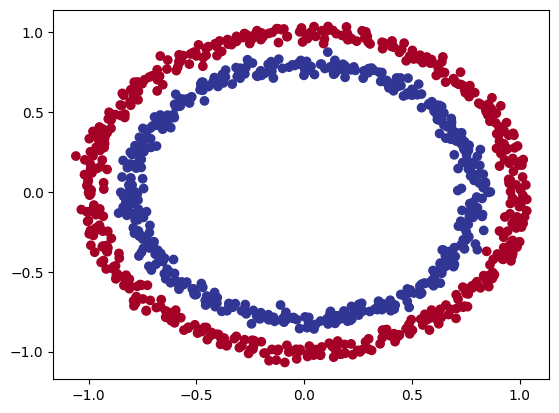

In [6]:
# Visualize, visualize, visualize
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'Values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [9]:
import torch
torch.manual_seed(42)
torch.__version__

'2.3.1'

In [10]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [11]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
type(X),X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [13]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model 

Let's build a model to classify our blue and red dots

In [15]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [16]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [17]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # Takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # Takes in 5 features from previous layer and outputs a single feature (same shape as y)

    # 3. Define a forward method
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

# 4. Instantiate an instance of our model class and send it to the target device
model_0 =   CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
# # Let's replicate the model above using nn.Sequential()
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)

# model_0

In [19]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(f'Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
    print(f'Length of test samples:: {len(X_test)}, Shape: {X_test.shape}')
    print(f'\nFirst 10 predictions:\n{untrained_preds[:10]}')
    print(f'\nFirst 10 labels:\n{y_test[:10]}')

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples:: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup a loss function and optimizer

For the loss function we're going to use `torch.nnBCEWithLogisticLoss`

In [20]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [21]:
# Calculate the accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train model

To train our model, we're going to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (Backpropagation)
5. Optimizer step (Gradient descend)

### 3.1 Going from raw logits -> Prediction probabilities -> prediction labels

Our models outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g sigmoid for binary classification and softmax for multiclass classification)

In [22]:
# View the first 5 outputs of the forward pass on the test data  
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
    
print(y_logits)

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]])


In [23]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [24]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]])

For our prediction probability values, we need to perform a range-style rounding on them

In [25]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.])

In [26]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [27]:
# Set the numbers of epochs
epochs = 100

# Put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, # nn.BCEWithLogitLoss expects raw logits as input
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. calculate the test/loss
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        # Print out what's happenin'
        if epoch % 10 == 0:
            print(f'Epoch: {epoch} | Loss:{loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss:0.69569, Acc: 50.00% | Test loss: 0.69721, Test acc: 50.00%
Epoch: 10 | Loss:0.69403, Acc: 50.00% | Test loss: 0.69615, Test acc: 50.00%
Epoch: 20 | Loss:0.69343, Acc: 46.00% | Test loss: 0.69585, Test acc: 48.50%
Epoch: 30 | Loss:0.69321, Acc: 49.00% | Test loss: 0.69577, Test acc: 47.50%
Epoch: 40 | Loss:0.69312, Acc: 49.50% | Test loss: 0.69573, Test acc: 46.50%
Epoch: 50 | Loss:0.69308, Acc: 50.38% | Test loss: 0.69569, Test acc: 46.50%
Epoch: 60 | Loss:0.69306, Acc: 50.50% | Test loss: 0.69564, Test acc: 46.50%
Epoch: 70 | Loss:0.69305, Acc: 50.50% | Test loss: 0.69559, Test acc: 46.50%
Epoch: 80 | Loss:0.69304, Acc: 50.75% | Test loss: 0.69553, Test acc: 46.50%
Epoch: 90 | Loss:0.69303, Acc: 50.38% | Test loss: 0.69547, Test acc: 46.50%


## 4. Make predictions and evaluate the model

From the metrics it looks our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, "Visualize, visualize, visualize"

To do so, we're going to import a function called `plot.decision_boundary()` `https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py`

In [28]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded )
if Path('helper_functions.py').is_file():
    print('helper_functions.py already exist, skipping download')
else:
    print('Downloading helper_functions.py')
    requests = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(requests.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exist, skipping download


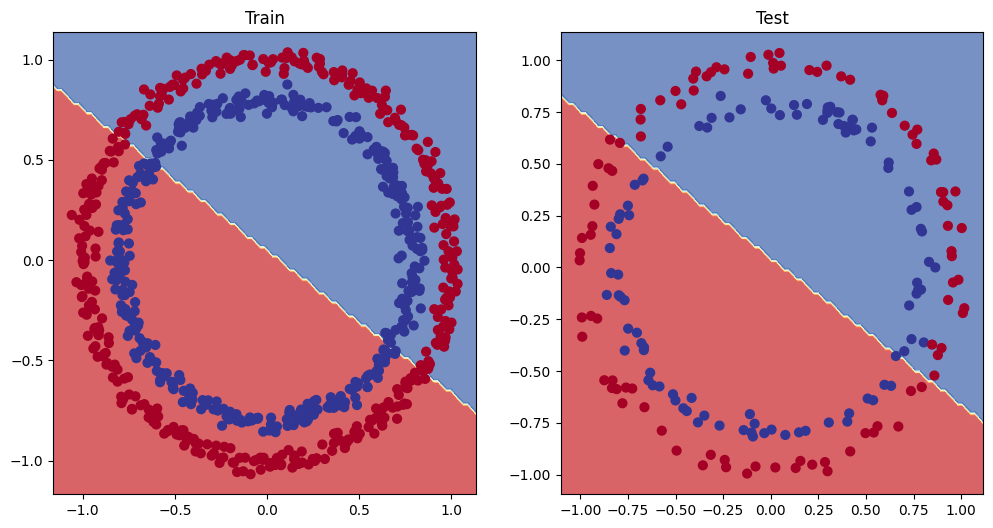

In [29]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

### 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

In [30]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5417,  0.5875],
                      [-0.1763,  0.6438],
                      [-0.1580,  0.1410],
                      [-0.3381,  0.4186],
                      [ 0.6194, -0.5209]])),
             ('layer_1.bias',
              tensor([0.6110, 0.1607, 0.5295, 0.0792, 0.3511])),
             ('layer_2.weight',
              tensor([[-0.0395,  0.3512,  0.1112, -0.1981,  0.1316]])),
             ('layer_2.bias', tensor([-0.1249]))])

In [31]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [33]:
# Write a training and evaluation loop for model_1
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the loss 
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
    
    # Print out what's happenin'
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.70021 | Acc: 51.50% | Test loss: 0.70111, Test acc: 53.00%
Epoch: 100 | Loss: 0.69308 | Acc: 50.25% | Test loss: 0.69443, Test acc: 48.50%
Epoch: 200 | Loss: 0.69299 | Acc: 51.00% | Test loss: 0.69440, Test acc: 47.00%
Epoch: 300 | Loss: 0.69298 | Acc: 51.50% | Test loss: 0.69446, Test acc: 46.00%
Epoch: 400 | Loss: 0.69298 | Acc: 51.50% | Test loss: 0.69451, Test acc: 45.00%
Epoch: 500 | Loss: 0.69298 | Acc: 51.38% | Test loss: 0.69455, Test acc: 45.00%
Epoch: 600 | Loss: 0.69298 | Acc: 51.25% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 700 | Loss: 0.69298 | Acc: 51.12% | Test loss: 0.69460, Test acc: 45.50%
Epoch: 800 | Loss: 0.69298 | Acc: 51.12% | Test loss: 0.69462, Test acc: 45.50%
Epoch: 900 | Loss: 0.69298 | Acc: 51.12% | Test loss: 0.69464, Test acc: 45.50%


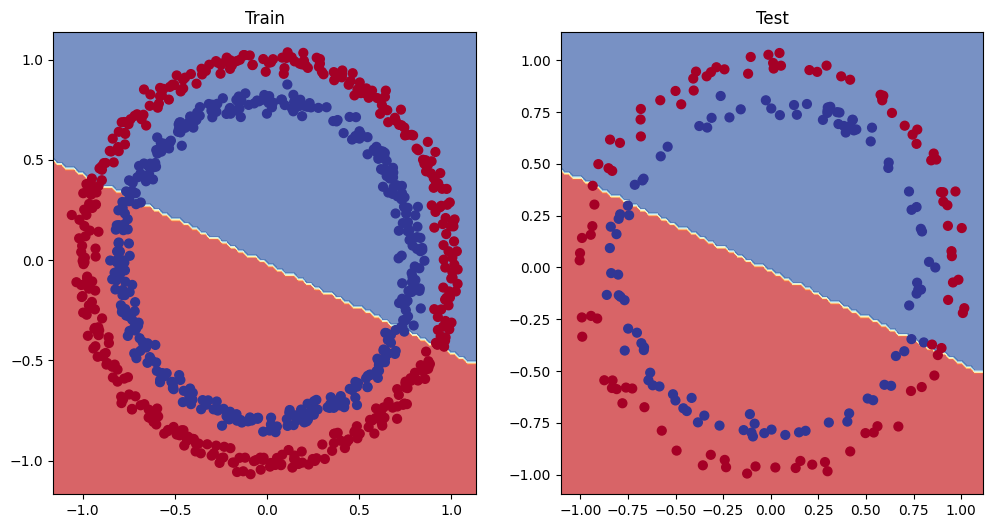

In [34]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Prepraring data to see if our model can fit a straight line

One way to troubleshoot to a larger problem it to test out a smaller problem

In [35]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data 
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data 
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [36]:
# Create train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

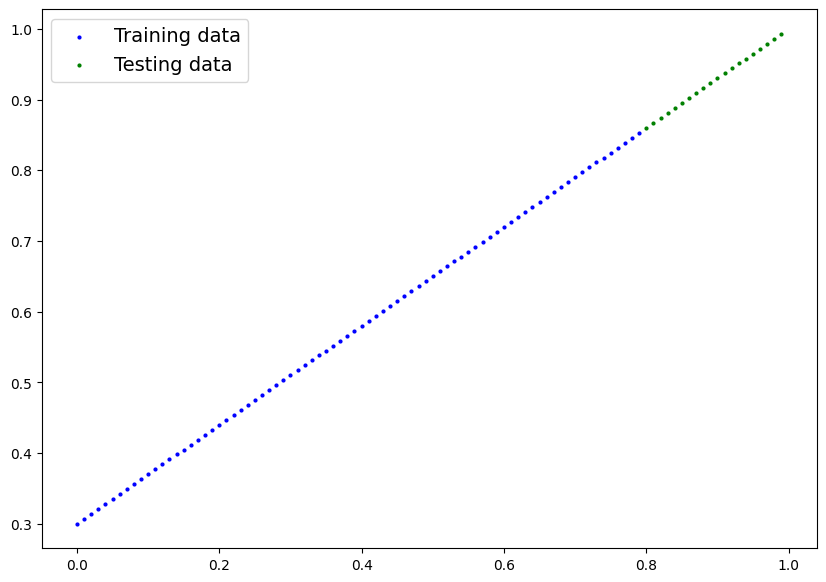

In [37]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [38]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [39]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.01)

In [40]:
# Train the model
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happenin'
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}')

Epoch: 0 | Loss: 0.78361 | Test loss: 0.98759
Epoch: 100 | Loss: 0.02265 | Test loss: 0.00501
Epoch: 200 | Loss: 0.02499 | Test loss: 0.00083
Epoch: 300 | Loss: 0.02447 | Test loss: 0.00139
Epoch: 400 | Loss: 0.02391 | Test loss: 0.00241
Epoch: 500 | Loss: 0.02240 | Test loss: 0.00225
Epoch: 600 | Loss: 0.02174 | Test loss: 0.00320
Epoch: 700 | Loss: 0.02016 | Test loss: 0.00290
Epoch: 800 | Loss: 0.01854 | Test loss: 0.00257
Epoch: 900 | Loss: 0.01775 | Test loss: 0.00324


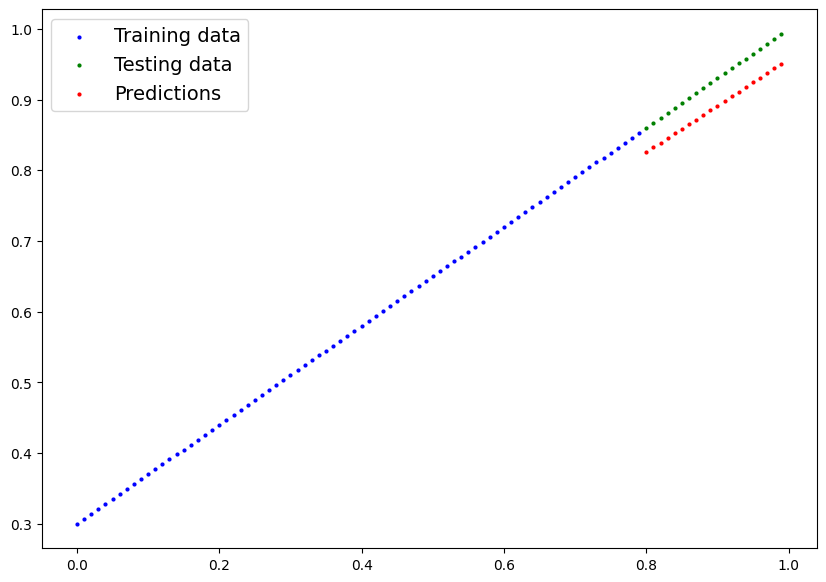

In [41]:
# Turn on evaluation mode
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is infinite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue)

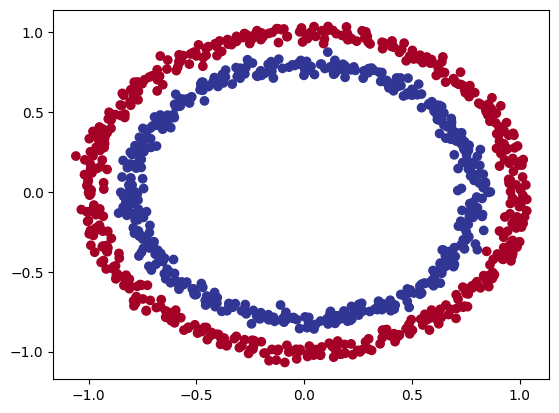

In [42]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [43]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [44]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [45]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.01)

### 6.3 Training a model with non-linearity

In [46]:
X_train.shape

torch.Size([800, 2])

In [47]:
# Random seeds
torch.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000
for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)


    # Print out what's happenin'
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}')

Epoch: 0 | Loss: 0.6959, Acc: 50.00 | Test loss: 0.6953, Test acc: 50.00
Epoch: 100 | Loss: 0.6946, Acc: 50.00 | Test loss: 0.6941, Test acc: 50.00
Epoch: 200 | Loss: 0.6938, Acc: 50.00 | Test loss: 0.6935, Test acc: 50.00
Epoch: 300 | Loss: 0.6933, Acc: 50.00 | Test loss: 0.6931, Test acc: 50.00
Epoch: 400 | Loss: 0.6930, Acc: 50.00 | Test loss: 0.6929, Test acc: 50.00
Epoch: 500 | Loss: 0.6927, Acc: 46.12 | Test loss: 0.6927, Test acc: 47.50
Epoch: 600 | Loss: 0.6924, Acc: 45.88 | Test loss: 0.6926, Test acc: 46.50
Epoch: 700 | Loss: 0.6922, Acc: 49.88 | Test loss: 0.6925, Test acc: 49.50
Epoch: 800 | Loss: 0.6920, Acc: 51.12 | Test loss: 0.6924, Test acc: 48.50
Epoch: 900 | Loss: 0.6917, Acc: 52.38 | Test loss: 0.6923, Test acc: 49.50


### 6.4 Evaluating a model trained with non-linear activations functions

In [48]:
# Let's make some predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([0., 0., 0., 0., 1., 1., 1., 1., 0., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

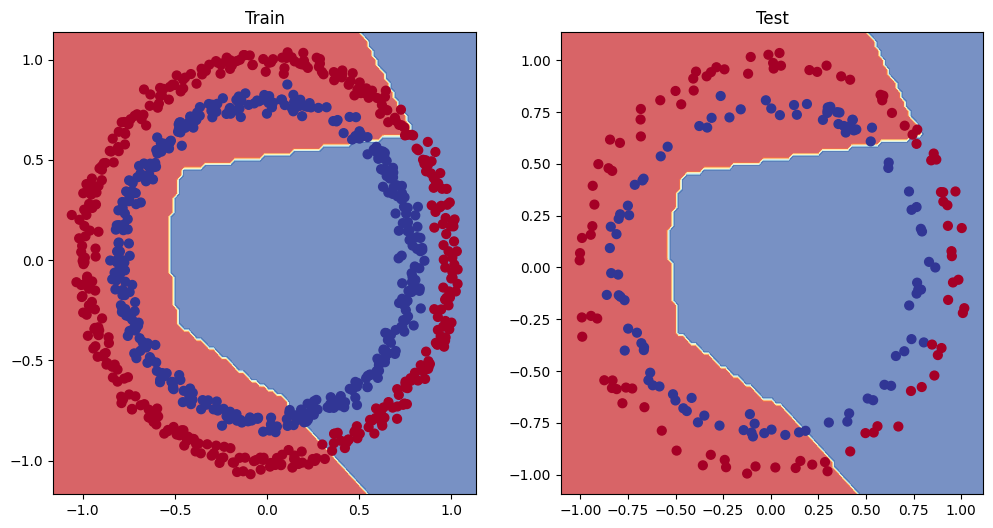

In [49]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

**Challengue:** Can you improve model_3 to do better than 80% accuracy on the test data?

## 7. Replicating non-linear activaction functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover the pattern in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions

In [50]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

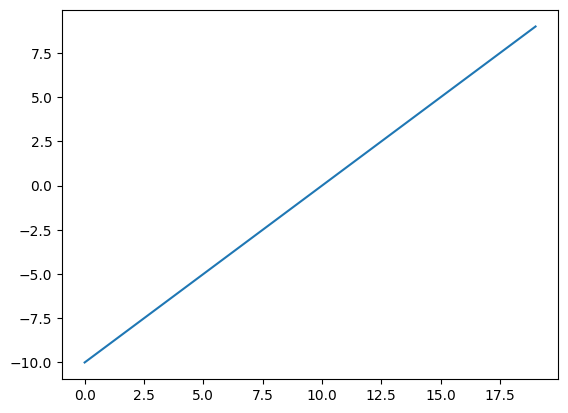

In [51]:
# Visualize the tensor
plt.plot(A)

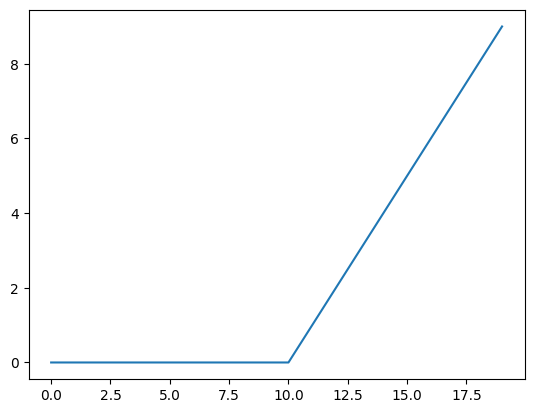

In [52]:
plt.plot(torch.relu(A))

In [53]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [54]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

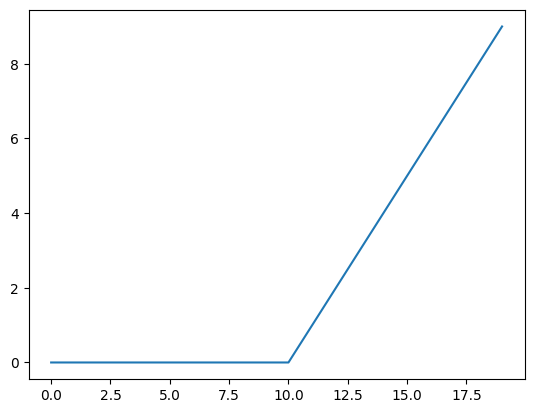

In [55]:
# Plot ReLu activation function
plt.plot(relu(A))